In [36]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import operator
from functools import reduce
from functools import partial

import time
import matplotlib.pyplot as plt

In [37]:
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial

#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        self.data = scipy.io.loadmat(self.file_path)
        self.old_mat = True
        # try:
        #     self.data = scipy.io.loadmat(self.file_path)
        #     self.old_mat = True
        # # except:
        # #     self.data = h5py.File(self.file_path)
        # #     self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c

In [38]:
def compl_mul2d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    return torch.einsum("bixy,ioxy->boxy", a, b)

class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.phi = DenseNet([2, 64, 128, in_channels*out_channels], torch.nn.ReLU)
        self.psi = DenseNet([2, 64, 128, in_channels*out_channels], torch.nn.ReLU)

    def get_grid(self, S1, S2, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S1), dtype=torch.float)
        gridx = gridx.reshape(1, S1, 1).repeat([batchsize, 1, S2])
        gridy = torch.tensor(np.linspace(0, 1, S2), dtype=torch.float)
        gridy = gridy.reshape(1, 1, S2).repeat([batchsize, S1, 1])
        return torch.stack((gridx, gridy), dim=-1).to(device)

    def forward(self, x, gridy=None):
        # x (batch, channel, x, y)
        # y (Ny, 2)
        batchsize, size1, size2 = x.shape[0], x.shape[2], x.shape[3]

        gridx = self.get_grid(S1=size1, S2=size2, batchsize=1, device=x.device).reshape(size1 * size2, 2)
        if gridy==None:
            gridy = self.get_grid(S1=size1, S2=size2, batchsize=1, device=x.device).reshape(size1 * size2, 2)
        Nx = size1 * size2
        Ny = gridy.shape[0]

        phi_eval = self.phi(gridx).reshape(Nx, self.out_channels, self.in_channels)
        psi_eval = self.psi(gridy).reshape(Ny, self.out_channels, self.in_channels)
        x = x.reshape(batchsize, self.in_channels, Nx)

        x = torch.einsum('noi,bin,moi->bom', phi_eval, x, psi_eval) / Nx
        return x

In [39]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x, size=None):

        if size==None:
            size = (x.size(2), x.size(3))

        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2,3])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, size[0], size[1]//2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(size[0], size[1]), dim=[2,3])

        return x

In [40]:
class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_dim=3, out_dim=1):
        super(SimpleBlock2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2

        self.width_list = [width*2//4, width*3//4, width*4//4, width*4//4, width*5//4]

        self.fc0 = nn.Linear(in_dim, self.width_list[0])

        self.conv0 = SpectralConv2d(
            self.width_list[0], self.width_list[1],
            self.modes1*4//4, self.modes2*4//4
        )
        self.conv1 = SpectralConv2d(self.width_list[1], self.width_list[2], self.modes1*3//4, self.modes2*3//4)
        self.conv2 = SpectralConv2d(self.width_list[2], self.width_list[3], self.modes1*2//4, self.modes2*2//4)
        self.conv3 = SpectralConv2d(self.width_list[3], self.width_list[4], self.modes1*1//4, self.modes2*1//4)
        self.w0 = nn.Conv1d(self.width_list[0], self.width_list[1], 1)
        self.w1 = nn.Conv1d(self.width_list[1], self.width_list[2], 1)
        self.w2 = nn.Conv1d(self.width_list[2], self.width_list[3], 1)
        self.w3 = nn.Conv1d(self.width_list[3], self.width_list[4], 1)
        self.k3 = LowRank2d(self.width_list[3], self.width_list[4])

        self.fc1 = nn.Linear(self.width_list[4], self.width_list[4]*2)
        # self.fc2 = nn.Linear(self.width_list[4]*2, self.width_list[4]*2)
        self.fc3 = nn.Linear(self.width_list[4]*2, out_dim)

    def forward(self, x, sub=1):

        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        size = (size_x*sub, size_y*sub)

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width_list[0], size_x*size_y)).view(batchsize, self.width_list[1], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[1], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width_list[1], size_x*size_y)).view(batchsize, self.width_list[2], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[2], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width_list[2], size_x*size_y)).view(batchsize, self.width_list[3], size_x, size_y)
        # x2 = F.interpolate(x2, size=size_list[3], mode='bilinear')
        x = x1 + x2
        x = F.elu(x)

        x1 = self.conv3(x, size)
        x2 = self.w3(x.view(batchsize, self.width_list[3], size_x*size_y)).view(batchsize, self.width_list[4], size_x, size_y)
        # x2 = self.k3(x).reshape(batchsize, self.width_list[4], size_x, size_y)
        # x2 = F.interpolate(x2, size=size, mode='bilinear')
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.fc3(x)
        return x

    def get_grid(self, S, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridx = gridx.reshape(1, 1, S, 1).repeat([batchsize, 1, 1, S])
        gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, S).repeat([batchsize, 1, S, 1])

        return torch.cat((gridx, gridy), dim=1).to(device)

In [41]:
class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x, sub=1):
        x = self.conv1(x, sub)
        return x


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

# Parameters

In [42]:
ntrain = 1024
ntest = 2048 - ntrain

sample_rate = 8
data_points = 1024 // sample_rate

sample_rate_t = 1
time_points = 101 // sample_rate_t

max_pad = 101

batch_size = 1
learning_rate = 0.001

epochs = 50
step_size = 5
gamma = 0.5

modes = 20
width = 64

num_runs = 3

# Load Data

In [43]:
data_loader = MatReader('burgers_v100_t100_r1024_N2048.mat')

x_data_raw = data_loader.read_field('input')[:,::sample_rate]
y_data_raw = data_loader.read_field('output')[:,::sample_rate_t,::sample_rate]

print(x_data_raw.shape)
print(y_data_raw.shape)

x_train = x_data_raw[:ntrain]
y_train = y_data_raw[:ntrain]

x_test = x_data_raw[ntrain:]
y_test = y_data_raw[ntrain:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


torch.Size([2048, 128])
torch.Size([2048, 101, 128])
torch.Size([1024, 128])
torch.Size([1024, 101, 128])
torch.Size([1024, 128])
torch.Size([1024, 101, 128])


In [44]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

# Method from pino_burger_fdm
# Repeats the 1D input to make it 2D
x_train = x_train.reshape(ntrain, 1, data_points).repeat([1,time_points,1])
x_test = x_test.reshape(ntest, 1, data_points).repeat([1,time_points,1])

In [45]:
def pad_data(x_train, x_test, pad_size):
    # Padded data
    padt_train = torch.zeros((ntrain, pad_size, data_points))
    x_train_pad = torch.cat([x_train, padt_train], 1)

    padt_test = torch.zeros((ntest, pad_size, data_points))
    x_test_pad = torch.cat([x_test, padt_test], 1)

    # Adding grids
    gridt_pad = torch.tensor(np.linspace(0,1,time_points+pad_size), dtype = torch.float)
    gridt_pad = gridt_pad.reshape(1,time_points+pad_size,1)
    gridx_pad = torch.tensor(np.linspace(0,1,data_points), dtype = torch.float)
    gridx_pad = gridx_pad.reshape(1,1,data_points)

    x_train_pad_grids = torch.stack([x_train_pad, gridx_pad.repeat([ntrain, time_points+pad_size, 1]), gridt_pad.repeat([ntrain, 1, data_points])], dim = 3)
    x_test_pad_grids = torch.stack([x_test_pad, gridx_pad.repeat([ntest, time_points+pad_size, 1]), gridt_pad.repeat([ntest, 1, data_points])], dim = 3)
    
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_pad_grids, y_train), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_pad_grids, y_test), batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [46]:
def train(train_loader, model, optimizer, scheduler, l2_loss, epoch):
    model.train()
    
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        output = model(data)
        
        # remove padding
        output = output.narrow(1, 0, time_points)
        
        # loss = F.mse_loss(output.view(batch_size,-1), target.view(batch_size,-1), reduction = 'sum')
        loss = l2_loss(output.view(batch_size, time_points, data_points), target.view(batch_size, time_points, data_points))

        total_loss += loss.item()

        loss.backward()

        optimizer.step()
    
    scheduler.step()
    
    return total_loss / ntrain

def test(test_loader, model, l2_loss):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            
            # remove padding
            output = output.narrow(1, 0, time_points)
            
            # loss += F.mse_loss(output.view(batch_size, -1), target.view(batch_size,-1), reduction = 'sum').item()
            loss += l2_loss(output.view(batch_size, time_points, data_points), target.view(batch_size, time_points, data_points)).item()
    
    return loss / ntest

In [47]:
train_loss_total = []
test_loss_total = []

# train_loss_total = np.empty(0)
# test_loss_total = np.empty(0)

for pad in range(0, max_pad, 5):
    print("Pad: " + str(pad))
    
    train_loss_pad = []
    test_loss_pad = []
    
#     train_loss_pad = np.empty(0)
#     test_loss_pad = np.empty(0)
    
    train_loader, test_loader = pad_data(x_train, x_test, pad)
    
    for run in range(num_runs):
        print("Run: " + str(run+1))
        
        train_loss_epoch = []
        test_loss_epoch = []
        
#         train_loss_epoch = np.empty(1)
#         test_loss_epoch = np.empty(1)
        
        model = Net2d(modes, width).cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)

        l2_loss = LpLoss(size_average=True)
        
        test_loss_initial = test(test_loader, model, l2_loss)
        
        test_loss_epoch.append(test_loss_initial)
        
#         np.append(test_loss_epoch, test_loss_initial, axis = 0)
        
        for epoch in range(epochs):
            # print("Epoch: "+str(epoch))
            
            train_loss = train(train_loader, model, optimizer, scheduler, l2_loss, epoch)
            
            train_loss_epoch.append(train_loss)
            
#             np.append(train_loss_epoch, train_loss, axis = 0)
            
            test_loss = test(test_loader, model, l2_loss)
            
            test_loss_epoch.append(test_loss)
            
#             np.append(test_loss_epoch, test_loss, axis = 0)

        
        train_loss_pad.append(train_loss_epoch)
        test_loss_pad.append(test_loss_epoch)
        
#         np.append(train_loss_pad, train_loss_epoch, axis = 0)
#         np.append(test_loss_pad, test_loss_epoch, axis = 0)
        
        print(run, test_loss_epoch[-1])
    
    train_loss_total.append(train_loss_pad)
    test_loss_total.append(test_loss_pad)
    
#     np.append(train_loss_total, train_loss_pad, axis = 0)
#     np.append(test_loss_total, test_loss_pad, axis = 0)
    
#     print(np.array(test_loss_total).shape)
    print("Pad Result:" + str(pad) + " " + str(np.mean(np.array(test_loss_total)[-1,:,-1])))

Pad: 0
Run: 1
0 0.006317845330613636
Run: 2
1 0.006750828126769193
Run: 3
2 0.006509462578605962
Pad Result:0 0.006526045345329597
Pad: 5
Run: 1
0 0.00734062399146751
Run: 2
1 0.007175190927227959
Run: 3
2 0.006937461965662806
Pad Result:5 0.007151092294786092
Pad: 10
Run: 1
0 0.007419163580379973
Run: 2
1 0.006981096746130788
Run: 3
2 0.007251851903220086
Pad Result:10 0.007217370743243616
Pad: 15
Run: 1
0 0.0067830368836894195
Run: 2
1 0.006843153563067972
Run: 3
2 0.006839338740974199
Pad Result:15 0.006821843062577197
Pad: 20
Run: 1
0 0.006736665254493346
Run: 2
1 0.0068946004087138135
Run: 3
2 0.00698363339165553
Pad Result:20 0.0068716330182875636
Pad: 25
Run: 1
0 0.006423077951239975
Run: 2
1 0.006552759733267521
Run: 3
2 0.00698578273795647
Pad Result:25 0.006653873474154655
Pad: 30
Run: 1
0 0.006355932373480755
Run: 2
1 0.006864058135988671
Run: 3
2 0.006650032046081833
Pad Result:30 0.006623340851850419
Pad: 35
Run: 1
0 0.006684910144258538
Run: 2
1 0.0063655681515228935
Run:

In [48]:
np.save('train_loss'+"_"+str(epochs)+"_"+str(step_size), train_loss_total)
np.save('test_loss'+"_"+str(epochs)+"_"+str(step_size), test_loss_total)

In [49]:
test_results = np.load("test_loss_50_5.npy")
train_results = np.load("train_loss_50_5.npy")

print(test_results.shape)
print(train_results.shape)

(21, 3, 51)
(21, 3, 50)


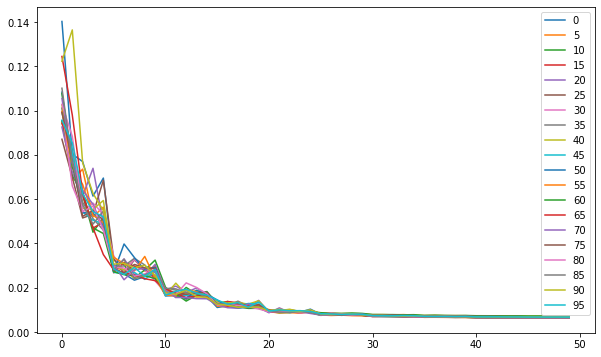

In [50]:
fig = plt.figure(figsize=(10,6))

for i in range(max_pad // 5):
    plt.plot(np.mean(test_results[i,:,1:], axis = 0), label = i*5)

plt.legend()
plt.show()

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


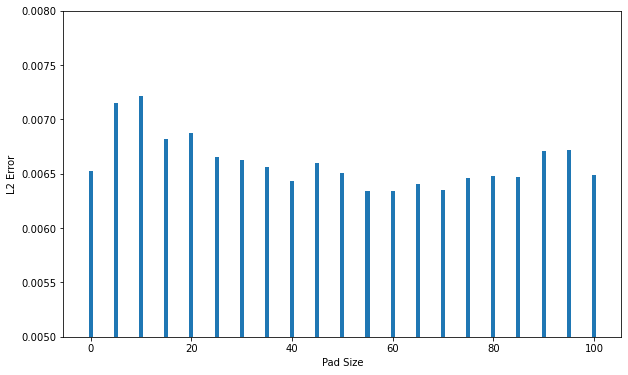

In [54]:
fig = plt.figure(figsize = (10,6))

plt.bar(np.arange(0,105,5),np.mean(test_results[:,:,-1], axis = 1))

ax = plt.axes()
ax.set_ylim([0.005, 0.008])

ax.set_ylabel("L2 Error")
ax.set_xlabel("Pad Size")
plt.show()